## Default Estimator and WoE Binning

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../data/final_df.csv')

In [3]:
from scripts.calculate_RFMS_score import RFMSRiskClassifier

### Construct the Default Estimator (Proxy)

- Use RFMS scores to create a boundary between "good" (low-risk) and "bad" (high-risk) customers.
- Visualize customer transactions in the RFMS space to understand where to establish the boundary.
- Based on the RFMS score, assign customers to "good" or "bad" risk categories.

In [4]:
current_date = '2024-10-05'
classifier = RFMSRiskClassifier(df)
classified_df, woe_results, iv_value = classifier.run(current_date)

In [5]:
print("Classified DataFrame:")
classified_df

Classified DataFrame:


,CustomerId,Recency,Frequency,Monetary,Seasonality,RFMS_score,Risk_category
0,CustomerId_4406,1.0,0.028851,0.055737,1.000000,0.521147,good
1,CustomerId_4406,1.0,0.028851,0.055737,1.000000,0.521147,good
2,CustomerId_4683,1.0,0.000244,0.000936,0.000000,0.250295,bad
3,CustomerId_988,1.0,0.009046,0.017819,1.000000,0.506716,good
4,CustomerId_988,1.0,0.009046,0.017819,1.000000,0.506716,good
...,...,...,...,...,...,...,...
95657,CustomerId_3078,0.0,0.139853,0.274333,0.333333,0.186880,bad
95658,CustomerId_3874,0.0,0.010269,0.020131,0.333333,0.090933,bad
95659,CustomerId_3874,0.0,0.010269,0.020131,0.333333,0.090933,bad
95660,CustomerId_1709,0.0,0.127873,0.247166,1.000000,0.343760,good


In [6]:
classified_df.Risk_category.value_counts()

Risk_category
good    47900
bad     47762
Name: count, dtype: int64

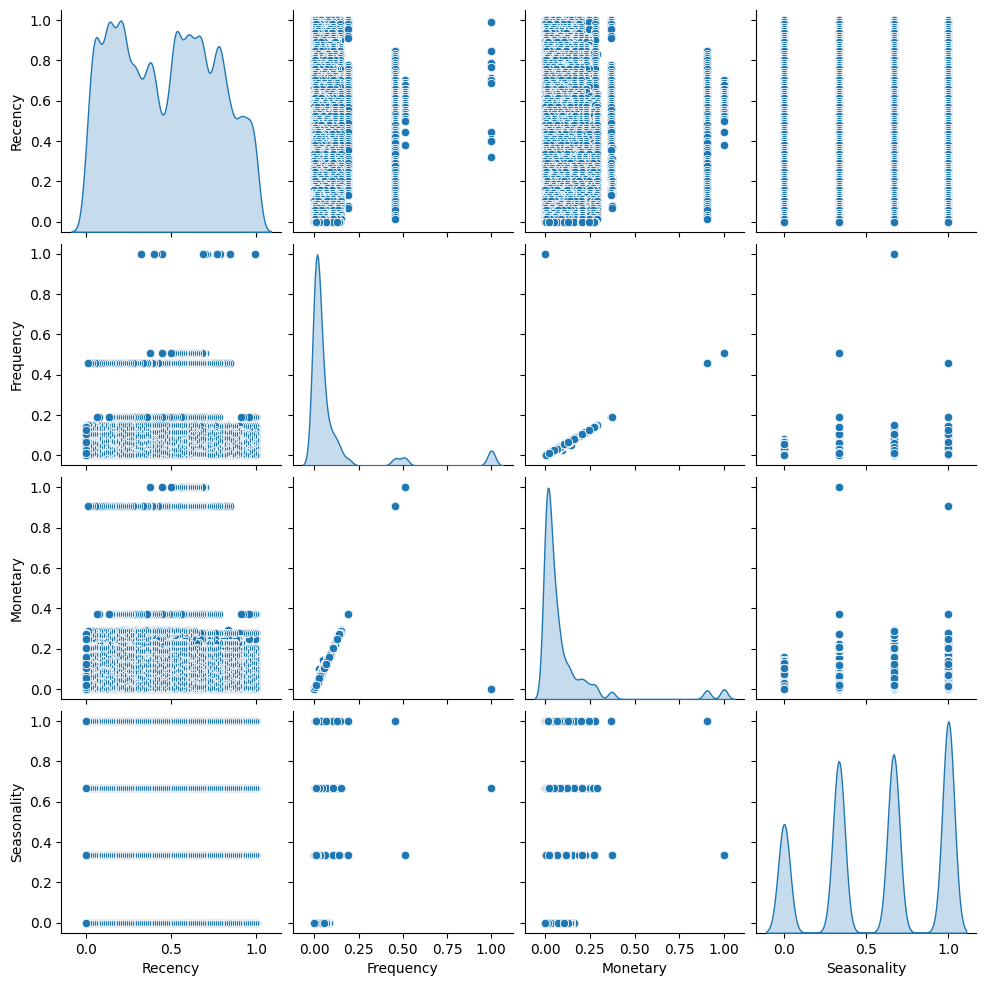

In [7]:
# We have RFMS columns: 'Recency', 'Frequency', 'Monetary', 'Seasonality'
# Scatter plot to visualize user segmentation in RFMS space
sns.pairplot(classified_df[['Recency', 'Frequency', 'Monetary', 'Seasonality']], diag_kind='kde')
plt.show()

### Perform Weight of Evidence (WoE) Binning

- Apply WoE binning to better separate customers into risk categories based on their RFMS scores.
- WoE binning helps identify which groups of RFMS scores are more strongly associated with default risk.

### 

In [7]:
print("\nWoE Results:")
woe_results


WoE Results:


Risk_category,bad,good,RFMS_bin,total_good,total_bad,good_dist,bad_dist,WoE,IV
0,19134,0,"(-0.000883, 0.166]",47900,47762,2.087683e-09,4.006114e-01,-19.072448,7.640639
1,19142,0,"(0.166, 0.261]",47900,47762,2.087683e-09,4.007789e-01,-19.072866,7.644001
2,9486,9635,"(0.261, 0.341]",47900,47762,2.011482e-01,1.986098e-01,0.012700,0.000032
3,0,19150,"(0.341, 0.459]",47900,47762,3.997912e-01,2.093715e-09,19.067513,7.623025
4,0,19115,"(0.459, 0.801]",47900,47762,3.990605e-01,2.093715e-09,19.065684,7.608362


In [8]:
woe_results.columns

Index(['bad', 'good', 'RFMS_bin', 'total_good', 'total_bad', 'good_dist',
       'bad_dist', 'WoE', 'IV'],
      dtype='object', name='Risk_category')

In [9]:
print(f"\nInformation Value (IV): {iv_value}")


Information Value (IV): 30.516059613041758


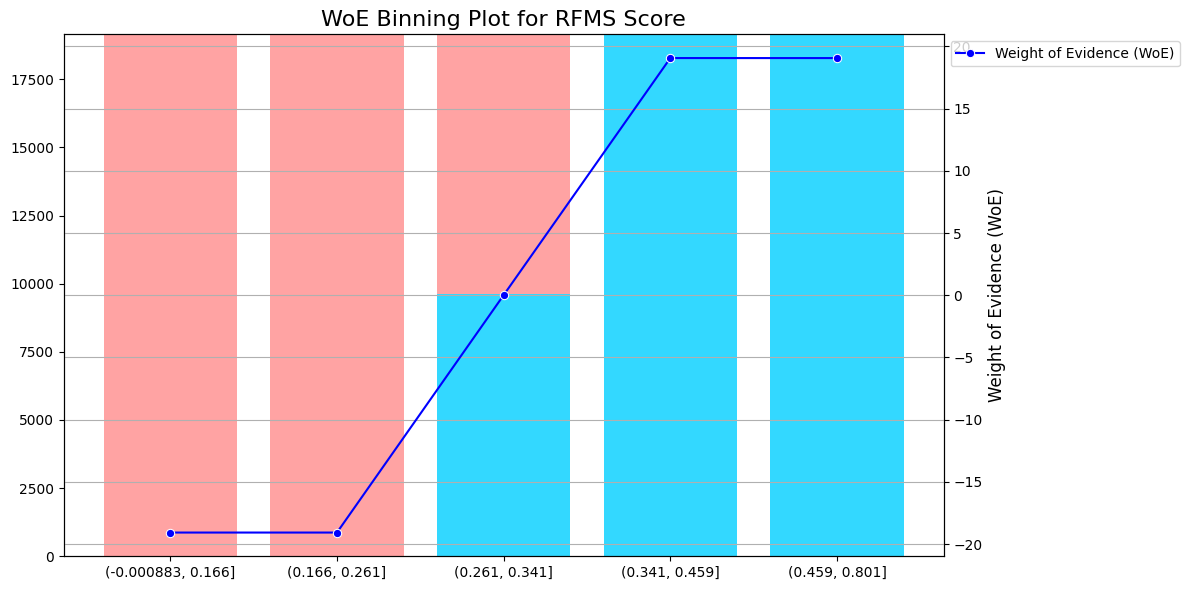

In [10]:
classifier.plot_woe(woe_results)

posx and posy should be finite values
posx and posy should be finite values


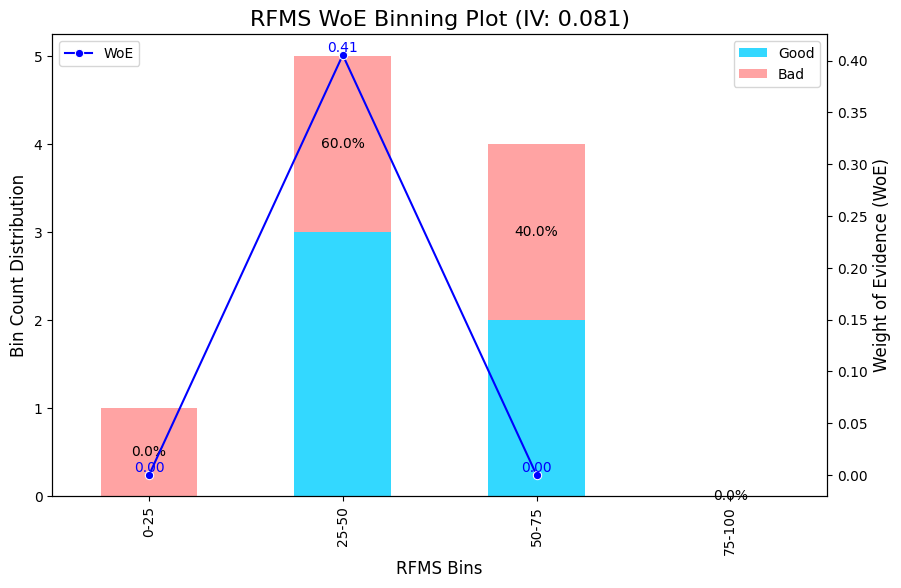

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample RFMS DataFrame creation
data = {
    'RFMS_Score': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
    'Target': [1, 1, 0, 0, 1, 0, 1, 1, 0, 0]  # 1 for good, 0 for bad
}
df = pd.DataFrame(data)

# Step 1: Binning
bins = [0, 25, 50, 75, 100]  # Define bin edges
labels = ['0-25', '25-50', '50-75', '75-100']  # Bin labels

df['RFMS_Bin'] = pd.cut(df['RFMS_Score'], bins=bins, labels=labels, right=False)

# Step 2: Create contingency table
contingency_table = df.groupby(['RFMS_Bin', 'Target']).size().unstack(fill_value=0)
contingency_table.columns = ['Good', 'Bad']

# Calculate total good and bad counts
total_good = contingency_table['Good'].sum()
total_bad = contingency_table['Bad'].sum()

# Calculate proportions
contingency_table['Good_dist'] = contingency_table['Good'] / total_good
contingency_table['Bad_dist'] = contingency_table['Bad'] / total_bad

# Step 3: Calculate WoE
contingency_table['WoE'] = np.log(contingency_table['Good_dist'] / contingency_table['Bad_dist']).replace([np.inf, -np.inf], 0)

# Step 4: Calculate IV
contingency_table['IV'] = (contingency_table['Good_dist'] - contingency_table['Bad_dist']) * contingency_table['WoE']
IV = contingency_table['IV'].sum()

# Reset index for plotting
contingency_table.reset_index(inplace=True)

# Step 5: Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting counts
contingency_table.plot(x='RFMS_Bin', y=['Good', 'Bad'], kind='bar', stacked=True, ax=ax1, color=['#00CFFF', '#FF8C8C'], alpha=0.8)

# Create second y-axis for WoE
ax2 = ax1.twinx()
sns.lineplot(data=contingency_table, x='RFMS_Bin', y='WoE', ax=ax2, color='blue', marker='o', label='WoE', sort=False)

# Adding percentage labels to bars
for i in range(len(contingency_table)):
    ax1.text(i, contingency_table['Good'].iloc[i] + contingency_table['Bad'].iloc[i] / 2, 
             f"{(contingency_table['Good'].iloc[i] / total_good * 100):.1f}%", 
             ha='center', va='center', color='black')
    
# Adding WoE labels
for i in range(len(contingency_table)):
    ax2.text(i, contingency_table['WoE'].iloc[i], 
             f"{contingency_table['WoE'].iloc[i]:.2f}", 
             ha='center', va='bottom', color='blue')

# Title and labels
ax1.set_title(f'RFMS WoE Binning Plot (IV: {IV:.3f})', fontsize=16)
ax1.set_xlabel('RFMS Bins', fontsize=12)
ax1.set_ylabel('Bin Count Distribution', fontsize=12)
ax2.set_ylabel('Weight of Evidence (WoE)', fontsize=12)

# Show legend
ax1.legend(['Good', 'Bad'], loc='upper right')
ax2.legend(['WoE'], loc='upper left')

plt.show()


In [14]:
df.shape

(95662, 42)

In [15]:
classified_df.shape

(95662, 7)